In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib,pprint,keras
import random

import FBNN2d,sei_kume,myResNet,FBNN3d
importlib.reload(FBNN2d)
importlib.reload(sei_kume)
importlib.reload(myResNet)
importlib.reload(FBNN3d)
from FBNN2d import *
from sei_kume import *
from myResNet import *
from FBNN3d import *

# １次元Fisher-Bingham分布
#### １次元Fisher-Bingham分布における、histのNormalizeの流れを具体的に書く

In [2]:
def mesh(x,y,Sigma,mu):
    # X,sig,ave = np.array([[x,y]]),np.array(Sigma),np.array([mu])
    # num=X@sig@X.T*(-0.5)+X@sig@ave.T
    num = -(Sigma[0][0]*x**2)/2 - (Sigma[1][1]*y**2)/2 - Sigma[0][1]*y*x
    num = num + (mu[0]*Sigma[0][0] + mu[1]*Sigma[0][1])*x + (mu[0]*Sigma[0][1] + mu[1]*Sigma[1][1])*y
    return np.exp(num)

[2.43844719 6.56155281]
[1.0, 0.9510565162951536, 0.8090169943749476, 0.587785252292473, 0.3090169943749475, 6.123233995736766e-17, -0.3090169943749476, -0.5877852522924729, -0.8090169943749475, -0.9510565162951536, -1.0, -0.9510565162951535, -0.8090169943749473, -0.5877852522924732, -0.3090169943749476, -1.8369701987210297e-16, 0.3090169943749473, 0.5877852522924736, 0.8090169943749473, 0.9510565162951535]
[0.0, 0.30901699437494745, 0.587785252292473, 0.8090169943749476, 0.9510565162951536, 1.0, 0.9510565162951536, 0.8090169943749476, 0.5877852522924731, 0.30901699437494756, 1.2246467991473532e-16, -0.3090169943749478, -0.5877852522924732, -0.8090169943749475, -0.9510565162951535, -1.0, -0.9510565162951538, -0.8090169943749471, -0.5877852522924732, -0.3090169943749477]
[54.598150033144236, 187.52779130060452, 345.43222693753387, 369.2669076352855, 237.80668112596123, 90.01713130052181, 18.893626661426218, 2.138724695201729, 0.14067620676446543, 0.006716550086478118, 0.0003354626279025

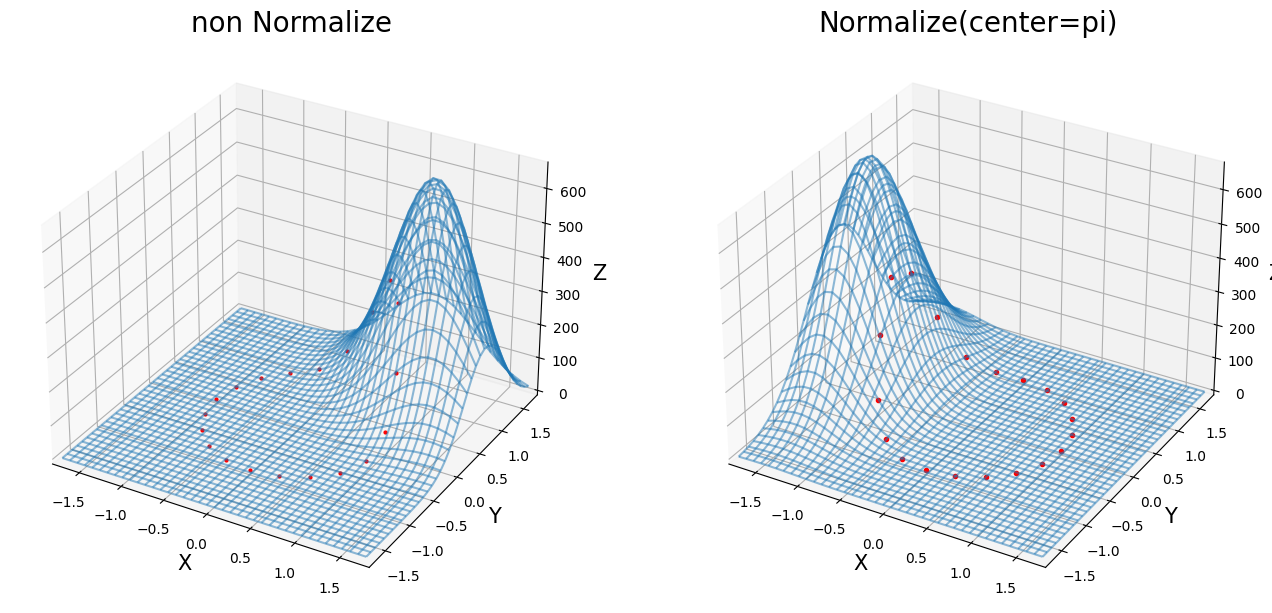

In [29]:
# Sigma=[[4,0],[0,4]]
# Sigma=np.zeros((2,2))
Sigma=[[4,2],[2,5]]
# Sigma=[[5,3],[3,5]]
mu=[1,1]
# mu=[0,0]
print(np.linalg.eig(Sigma)[0])
myhist = hist_gene(Sigma,mu,multi=-1)
# Z=myhist
X=[]
Y=[]
for rad in range(0, 20, 1):
    rad=rad*0.1*np.pi
    X.append(np.cos(rad))
    Y.append(np.sin(rad))

print(X)
print(Y)
print(myhist)

fig = plt.figure(figsize=(16,9))
# fig, axes = plt.subplots(ncols=2, figsize=(14, 5),projection='3d')
# ax,ax2=axes[0],axes[1]
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot(X,Y,myhist,marker="o",markersize=2,linestyle='None',color="r")

lim=1.75
# lim=2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_title("non Normalize", fontsize=20)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)
# x = np.linspace(-4, 4, 40)
# y = np.linspace(-4, 4, 40)
x = np.linspace(-lim, lim, 40)
y = np.linspace(-lim, lim, 40)
X2, Y2 = np.meshgrid(x, y)
ax.plot_wireframe(X2, Y2, mesh(X2,Y2,Sigma,mu), alpha=0.5)

# plt.show()


newhist,newSig,newmu,rad = hist_Normalize(myhist,Sigma,mu,center=np.pi)
print(rad)

# fig = plt.figure()
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.plot(X,Y,newhist,marker="o",markersize=3,linestyle='None',color="r")
ax2.set_xlim(-lim,lim)
ax2.set_ylim(-lim,lim)
ax2.set_title("Normalize(center=pi)", fontsize=20)
ax2.set_xlabel("X", fontsize=15)
ax2.set_ylabel("Y", fontsize=15)
ax2.set_zlabel("Z", fontsize=15)

# lim=1.5
# x = np.linspace(-4, 4, 40)
# y = np.linspace(-4, 4, 40)
# x = np.linspace(-lim, lim, 40)
# y = np.linspace(-lim, lim, 40)
# X2, Y2 = np.meshgrid(x, y)
ax2.plot_wireframe(X2, Y2, mesh(X2,Y2,newSig,newmu), alpha=0.5)

plt.show()

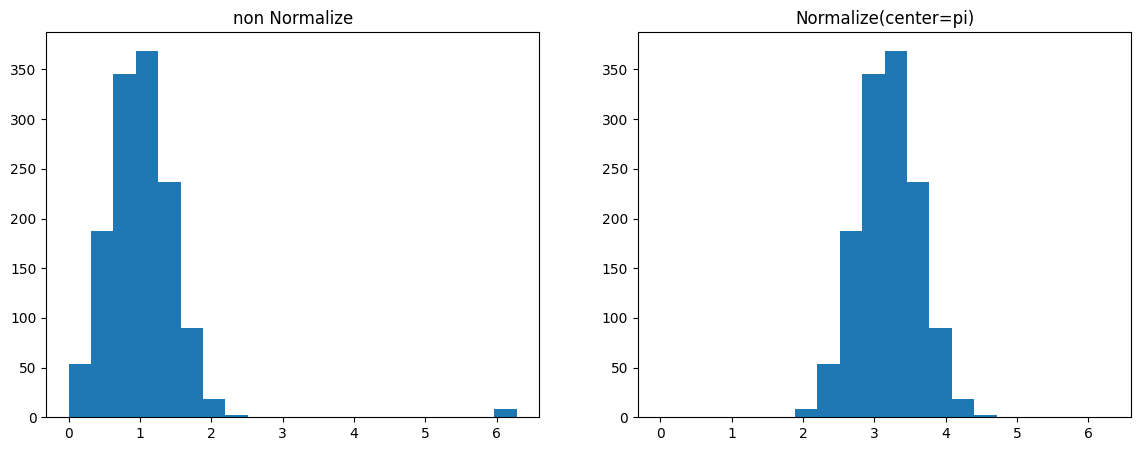

In [42]:
plt_hist=[]
plt_hist2=[]
for i in range(20):
    pi=i*0.1*np.pi
    for j in range(int(myhist[i])):
        plt_hist.append(pi)
    for _ in range(int(newhist[i])):
        plt_hist2.append(pi)
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].hist(plt_hist, range=(0,2*np.pi),bins=20)
axes[0].set_title("non Normalize")
axes[1].hist(plt_hist2,range=(0,2*np.pi),bins=20)
axes[1].set_title("Normalize(center=pi)")

plt.show()

#### myhistのみから元のSig,muを最尤推定する過程

[54.598150033144236, 187.52779130060452, 345.43222693753387, 369.2669076352855, 237.80668112596123, 90.01713130052181, 18.893626661426218, 2.138724695201729, 0.14067620676446543, 0.006716550086478118, 0.0003354626279025121, 2.739941042618433e-05, 5.601920906637093e-06, 3.847291209400771e-06, 9.621243100564776e-06, 7.485182988770046e-05, 0.0012712397874336129, 0.029819128984750365, 0.6174951684341591, 8.030603156544112]
[ 3.6070042   0.08929387  3.0293386  -4.54834     0.3751836 ]
[3.620492  3.0158508]
[3.01585074 3.62049203]


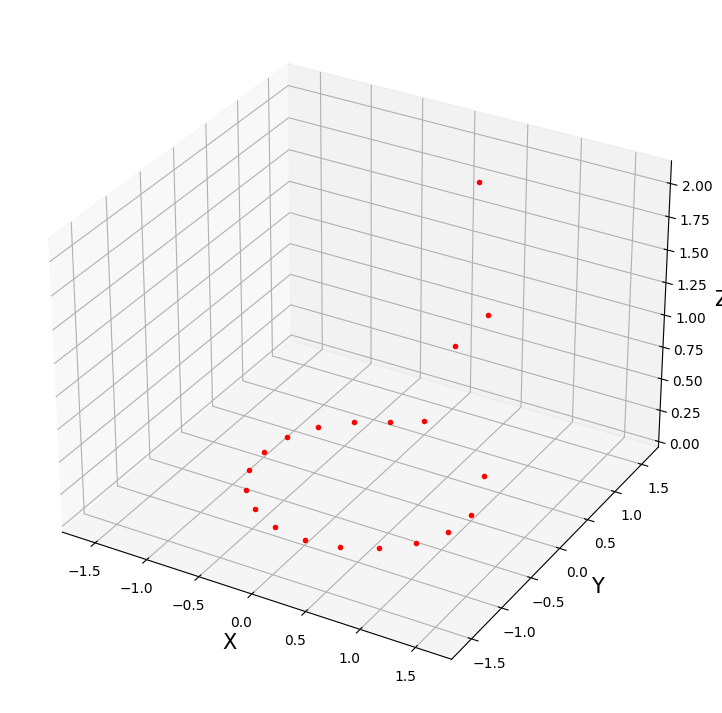

In [30]:
print(myhist)
avehist=ave(myhist)
normhist,normrad = hist_Normalize(avehist,center=np.pi)
# model = keras.models.load_model("./models/mymodel_0startN2.h5", compile=False)
# y_pred=model.predict([normhist],verbose=0)[0]
# model = keras.models.load_model("./models/mymodel_0start2.h5", compile=False)
# y_pred=model.predict([avehist],verbose=0)[0]
model = keras.models.load_model("./models/mymodel_1start3.h5", compile=False)
y_pred=model.predict([normhist],verbose=0)[0]
print(y_pred)

Sig00 = np.array([y_pred[0:2],y_pred[1:3]])
mu00 = np.array(y_pred[3:5])
hist00 = hist_gene(Sig00,mu00,multi=-1)
print(np.linalg.eig(Sig00)[0])

hist0,Sig0,mu0,rad0 = hist_rot(hist00,-normrad,Sig00,mu00)
print(np.linalg.eig(Sig0)[0])

# fig = plt.figure(figsize=(16,9))
fig = plt.figure(figsize=(10,9))
# ax3 = fig.add_subplot(1,2,1,projection='3d')
ax3 = fig.add_subplot(projection='3d')
ax3.plot(X,Y,hist0,marker="o",markersize=3,linestyle='None',color="r")

# lim=1.75
# lim=10
ax3.set_xlim(-lim,lim)
ax3.set_ylim(-lim,lim)
# ax3.set_title("non Normalize", fontsize=20)
ax3.set_xlabel("X", fontsize=15)
ax3.set_ylabel("Y", fontsize=15)
ax3.set_zlabel("Z", fontsize=15)
# x = np.linspace(-lim, lim, 40)
# y = np.linspace(-lim, lim, 40)
# X2, Y2 = np.meshgrid(x, y)
# ax3.plot_wireframe(X2, Y2, mesh(X2,Y2,Sig0,mu0), alpha=0.5)

plt.show()

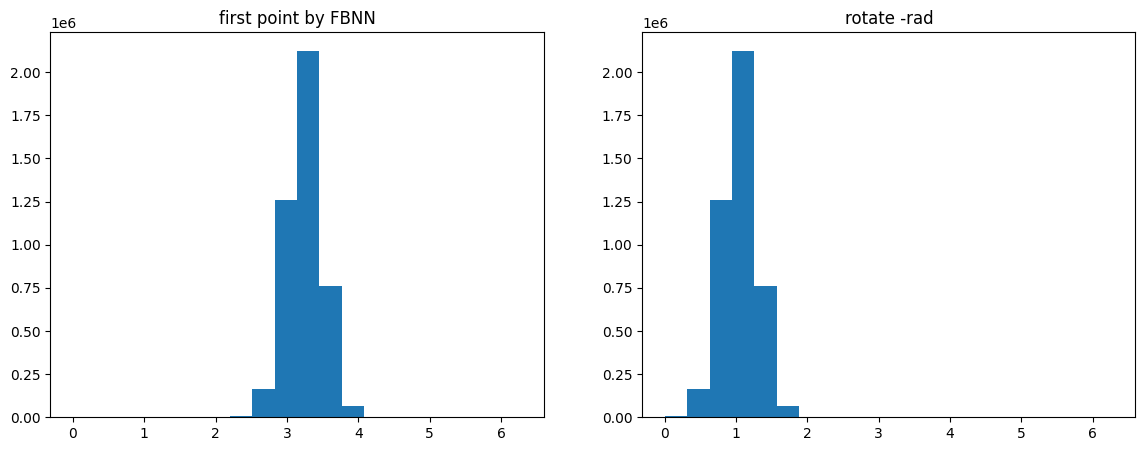

In [ ]:
plt_hist=[]
plt_hist2=[]
for i in range(20):
    pi=i*0.1*np.pi
    for j in range(int(hist00[i])):
        plt_hist.append(pi)
    for _ in range(int(hist0[i])):
        plt_hist2.append(pi)
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].hist(plt_hist, range=(0,2*np.pi),bins=20)
axes[0].set_title("first point by FBNN")
axes[1].hist(plt_hist2,range=(0,2*np.pi),bins=20)
axes[1].set_title("rotate -rad")

plt.show()

In [5]:
# Sig0,mu0 = rot(-rad)@Sig0@rot(-rad).T, rot(rad).T@mu0
O00 = np.linalg.eig(Sig00)[1].T
O00 = np.diag(np.sign(O00@Sig00@mu00)+1e-3)@O00
th00 = np.diag(O00@Sig00@O00.T)/2
ga00 = O00@Sig00@mu00
# ths = np.argsort(np.array(th00))
# th00,ga00 = [th00[s] for s in ths] ,[ga00[s] for s in ths]
# Q = np.zeros((len(ths),len(ths)))
# for i in range(len(ths)): Q[i][ths[i]]=1
# O00 = Q@O00

A0,B0,n = AB_gene(avehist)
pprint.pprint(Loglikelihood(th00,ga00,A0,B0,O=O00,n=1,method="hg"))

{'grad': array([ 0.33637815, -0.33610446, -1.65387067,  0.38729372]),
 'log': -25.29191743881522}


In [6]:
# Sig0,mu0 = rot(-rad)@Sig0@rot(-rad).T, rot(rad).T@mu0
O0 = np.linalg.eig(Sig0)[1].T
O0 = np.diag(np.sign(O0@Sig0@mu0)+1e-3)@O0
th0 = np.diag(O0@Sig0@O0.T)/2
ga0 = O0@Sig0@mu0
# ths = np.argsort(np.array(th0))
# th0,ga0 = [th0[s] for s in ths] ,[ga0[s] for s in ths]
# Q = np.zeros((len(ths),len(ths)))
# for i in range(len(ths)): Q[i][ths[i]]=1
# O0 = Q@O0

A,B,n = AB_gene(avehist)
pprint.pprint(Loglikelihood(th0,ga0,A,B,O=O0,n=1,method="hg"))

mle = optimisation(th0,ga0,A,B,n=1,O=O0,orth="yes",tol=1e-4,iterss=200,t0=1,sqrt=False)
pprint.pprint(mle)

{'grad': array([-0.1000057 ,  0.1020047 ,  0.03668109, -0.06486514]),
 'log': -0.9452056689388098}
0.3585899155436554 0.665448812582635 -2.3432406373741106
0.0 1.6926535818387293e-05
iteration
1 0.3585899155436554 0.665448812582635 1.2946990706345907 -0.8222953872094525 1.520945250164658
-0.07732068060267058 0.0027333798045051116
iteration
2 0.14527856559160446 0.13189750430088054 0.2048390513391593 -0.8073942006181536 0.01490118659129891
-0.07891540047192881 0.0027785668637587075
iteration
3 0.1412527718474479 0.13136185495512231 0.20048507377703198 -0.7931704809653208 0.014223719652832756
-0.08049581352624252 0.002461347737095348
iteration
4 0.13737245263900943 0.13048033380883028 0.19610765074327283 -0.779638399046787 0.013532081918533834
-0.0820548984680364 0.002159838933697831
iteration
5 0.13348420213163648 0.12954910568122635 0.19169147441621467 -0.7667546854826242 0.012883713564162846
-0.08372463535236038 0.0018757623905506886
iteration
6 0.1295982084711329 0.1285274030452297 0

In [33]:
th=mle["th"]
ga=mle["gg"]
O=mle["O"]

Sig_p = O.T@np.diag(th*2)@O
# Sig_p = O.T@np.diag(th*1.55)@O
# mu_p = np.linalg.inv(Sig_p)@O.T@ga
mu_p = np.linalg.pinv(Sig_p)@O.T@ga
print(Sig_p)
print(mu_p)

[[5.16394566 4.35798853]
 [4.35798853 7.99107832]]
[0.94268676 0.7643794 ]


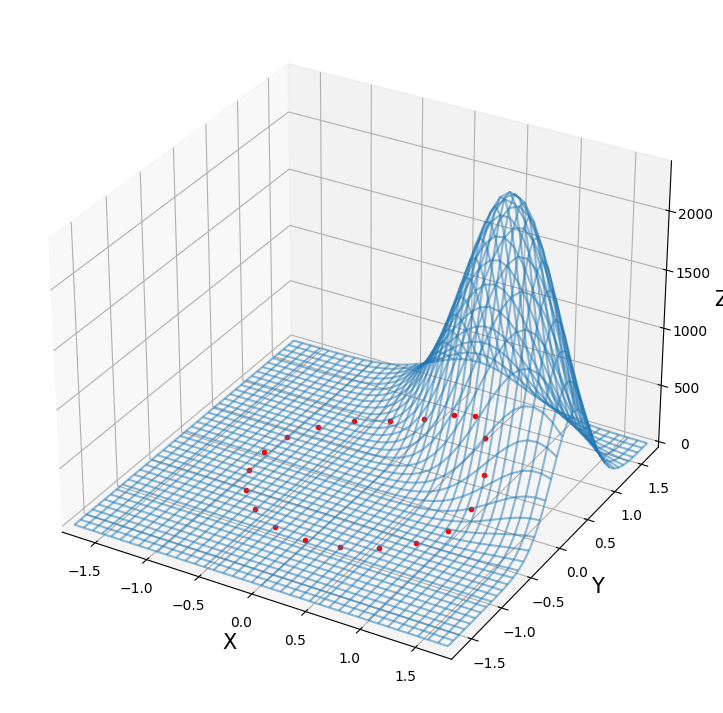

In [31]:
# fig = plt.figure(figsize=(16,9))
fig = plt.figure(figsize=(10,9))
# ax3 = fig.add_subplot(1,2,1,projection='3d')
ax3 = fig.add_subplot(projection='3d')
ax3.plot(X,Y,myhist,marker="o",markersize=3,linestyle='None',color="r")

lim=1.75
# lim=5
ax3.set_xlim(-lim,lim)
ax3.set_ylim(-lim,lim)
# ax3.set_title("non Normalize", fontsize=20)
ax3.set_xlabel("X", fontsize=15)
ax3.set_ylabel("Y", fontsize=15)
ax3.set_zlabel("Z", fontsize=15)
x = np.linspace(-lim, lim, 40)
y = np.linspace(-lim, lim, 40)
X2, Y2 = np.meshgrid(x, y)
ax3.plot_wireframe(X2, Y2, mesh(X2,Y2,Sig_p,mu_p), alpha=0.5)

plt.show()

{'grad': array([ 0.00272228, -0.00072328, -0.00158821, -0.00069151]),
 'log': -0.5648311020122287}
{'grad': array([ 3.74463942e-04,  1.62453606e-03, -2.93639931e-05, -1.00245315e-03]),
 'log': -0.5628222721474287}


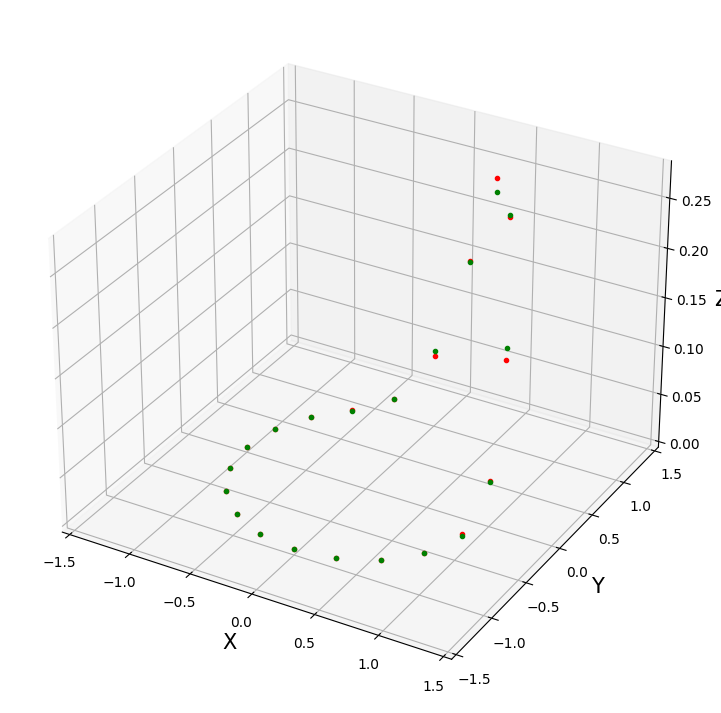

In [34]:
Sig_T,mu_T=Sigma,mu
O_T = np.linalg.eig(Sig_T)[1].T
O_T = np.diag(np.sign(O_T@Sig_T@mu_T)+1e-3)@O_T
th_T = np.diag(O_T@Sig_T@O_T.T)/2
ga_T = O_T@Sig_T@mu_T
pprint.pprint(Loglikelihood(th,ga,A,B,O=O,n=1,method="hg"))
pprint.pprint(Loglikelihood(th_T,ga_T,A,B,O=O_T,n=1,method="hg"))

hist_p = ave(hist_gene(Sig_p,mu_p,multi=-1))

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(projection='3d')
ax.plot(X,Y,avehist,marker="o",markersize=3,linestyle='None',color="r")
ax.plot(X,Y,hist_p,marker="o",markersize=3,linestyle='None',color="g")
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)
lim=1.5
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
plt.show()

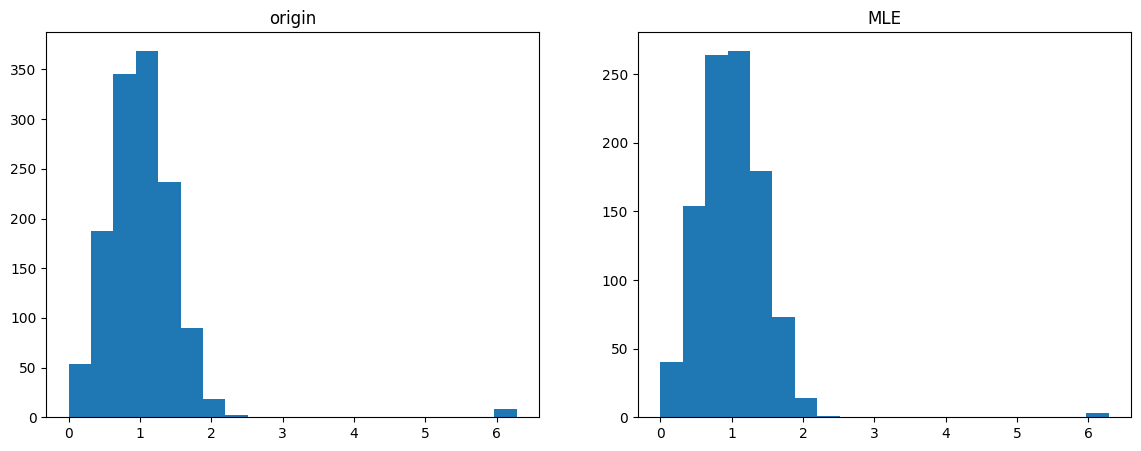

In [52]:
plt_hist=[]
plt_hist2=[]
for i in range(20):
    pi=i*0.1*np.pi
    for j in range(int(myhist[i])):
        plt_hist.append(pi)
    for _ in range(int(hist_p[i]*1e3)):
        plt_hist2.append(pi)
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].hist(plt_hist, range=(0,2*np.pi),bins=20)
axes[0].set_title("origin")
axes[1].hist(plt_hist2,range=(0,2*np.pi),bins=20)
axes[1].set_title("MLE")

plt.show()

# 2次元Fisher-Bingham分布

#### サンプル点の取る座標

[0.4358898943540673, 0.3526423322087409, 0.13469738503170728, -0.1346973850317073, -0.35264233220874086, -0.4358898943540673, -0.35264233220874086, -0.1346973850317073, 0.13469738503170717, 0.35264233220874086, 0.7141428428542851, 0.5777536962803542, 0.22068227485321162, -0.2206822748532117, -0.5777536962803541, -0.7141428428542851, -0.5777536962803541, -0.2206822748532117, 0.22068227485321149, 0.5777536962803541, 0.8660254037844385, 0.7006292692220367, 0.2676165673298175, -0.2676165673298176, -0.7006292692220366, -0.8660254037844385, -0.7006292692220366, -0.2676165673298176, 0.26761656732981726, 0.7006292692220366, 0.9539392014169458, 0.7717530255467752, 0.2947834248383022, -0.29478342483830233, -0.771753025546775, -0.9539392014169458, -0.7717530255467749, -0.29478342483830233, 0.29478342483830206, 0.7717530255467749, 0.9949874371066199, 0.8049617458088297, 0.3074680272555198, -0.3074680272555199, -0.8049617458088296, -0.9949874371066199, -0.8049617458088295, -0.3074680272555199, 0.30

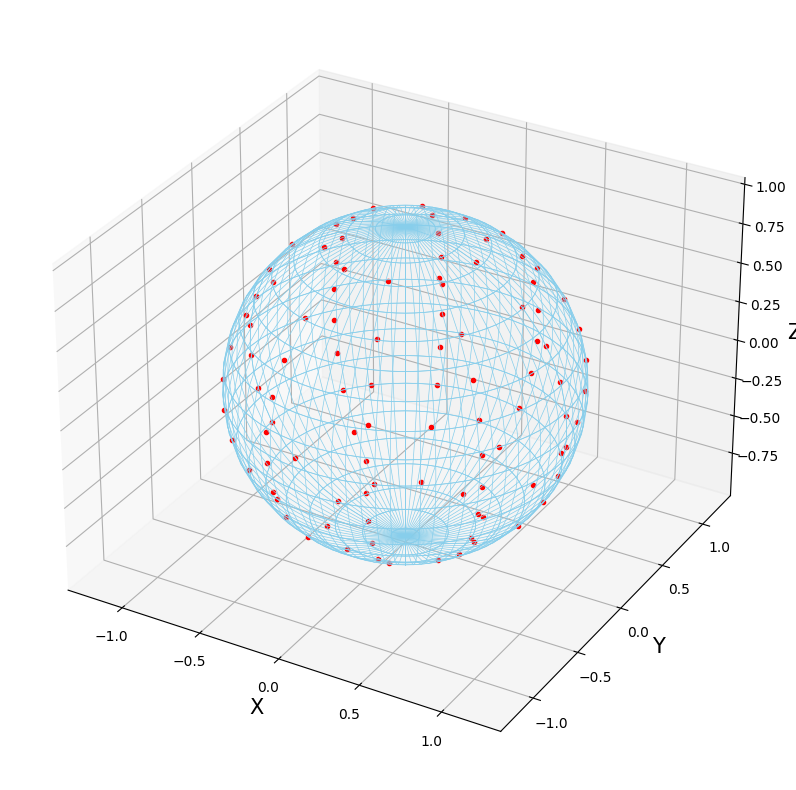

In [28]:
X=[]
Y=[]
Z=[]

eps=0.05
for i in range(10):
    for j in range(10):
        th=np.arccos(-2*(i*0.1+eps)+1)
        phi=2*np.pi*(j*0.1)
        X.append(np.sin(th)*np.cos(phi))
        Y.append(np.sin(th)*np.sin(phi))
        Z.append(np.cos(th))

print(X)
print(Y)
print(Z)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot(X,Y,Z,marker="o",markersize=3,linestyle='None',color="r")

lim=1.3
# lim=2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
# ax.set_zlim(-lim,lim)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)


th1,th2 = np.mgrid[0:2*np.pi:40j,0:2*np.pi:40j]
x = np.cos(th1)*np.sin(th2)
y = np.sin(th1)*np.sin(th2)
z = np.cos(th2)

ax.plot_wireframe(x, y, z, color="skyblue", linewidth=0.5)

plt.show()

[-0.35264233220874086, -0.1346973850317073, 0.13469738503170717, 0.35264233220874086, 0.4358898943540673, -0.5777536962803541, -0.2206822748532117, 0.22068227485321149, 0.5777536962803541, 0.7141428428542851, -0.7006292692220366, -0.2676165673298176, 0.26761656732981726, 0.7006292692220366, 0.8660254037844385, -0.7717530255467749, -0.29478342483830233, 0.29478342483830206, 0.7717530255467749, 0.9539392014169458, -0.8049617458088295, -0.3074680272555199, 0.3074680272555196, 0.8049617458088295, 0.9949874371066199, -0.8049617458088295, -0.3074680272555199, 0.3074680272555196, 0.8049617458088295, 0.9949874371066199, -0.7717530255467749, -0.29478342483830233, 0.29478342483830206, 0.7717530255467749, 0.9539392014169458, -0.7006292692220366, -0.2676165673298176, 0.26761656732981726, 0.7006292692220366, 0.8660254037844385, -0.577753696280354, -0.22068227485321168, 0.22068227485321143, 0.577753696280354, 0.714142842854285, -0.3526423322087406, -0.13469738503170722, 0.13469738503170708, 0.352642

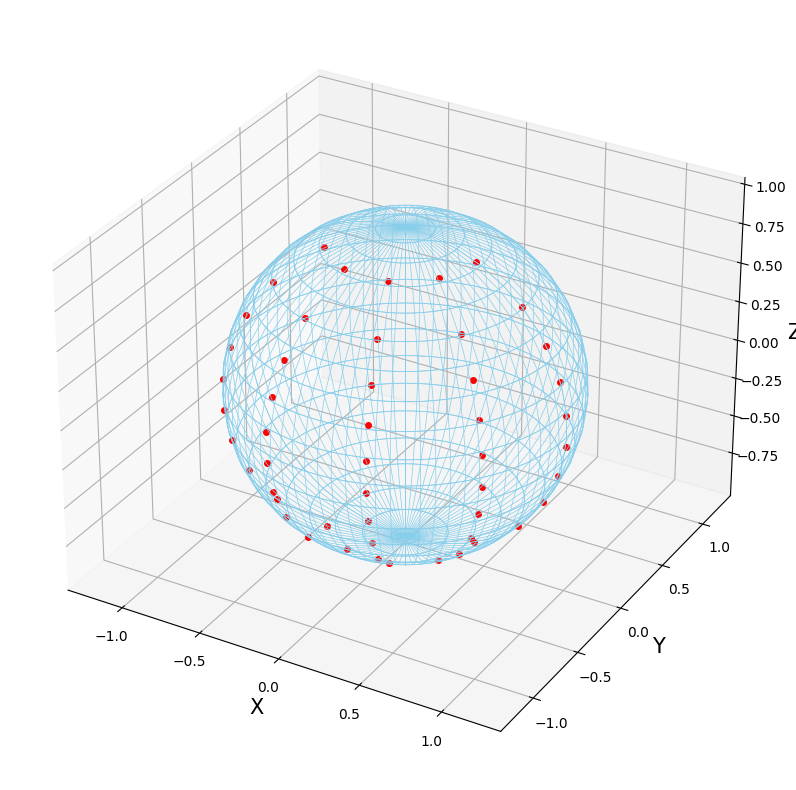

In [25]:
X=[]
Y=[]
Z=[]

eps=0.05
for i in range(10):
    for j in range(6,11):
        th=np.arccos(-2*(i*0.1+eps)+1)
        phi=2*np.pi*(j*0.1)
        X.append(np.sin(th)*np.cos(phi))
        Y.append(np.sin(th)*np.sin(phi))
        Z.append(np.cos(th))

print(X)
print(Y)
print(Z)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot(X,Y,Z,marker="o",markersize=4,linestyle='None',color="r")

lim=1.3
# lim=2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
# ax.set_zlim(-lim,lim)
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("Y", fontsize=15)
ax.set_zlabel("Z", fontsize=15)


th1,th2 = np.mgrid[0:2*np.pi:40j,0:2*np.pi:40j]
# 2*0.6*np.pi:2*1.1*np.pi:20j
x = np.cos(th1)*np.sin(th2)
y = np.sin(th1)*np.sin(th2)
z = np.cos(th2)

ax.plot_wireframe(x, y, z, color="skyblue", linewidth=0.5)

plt.show()
# 半分だけ

#### 最尤推定の過程

[1. 1. 1.]
2.5132741228718345


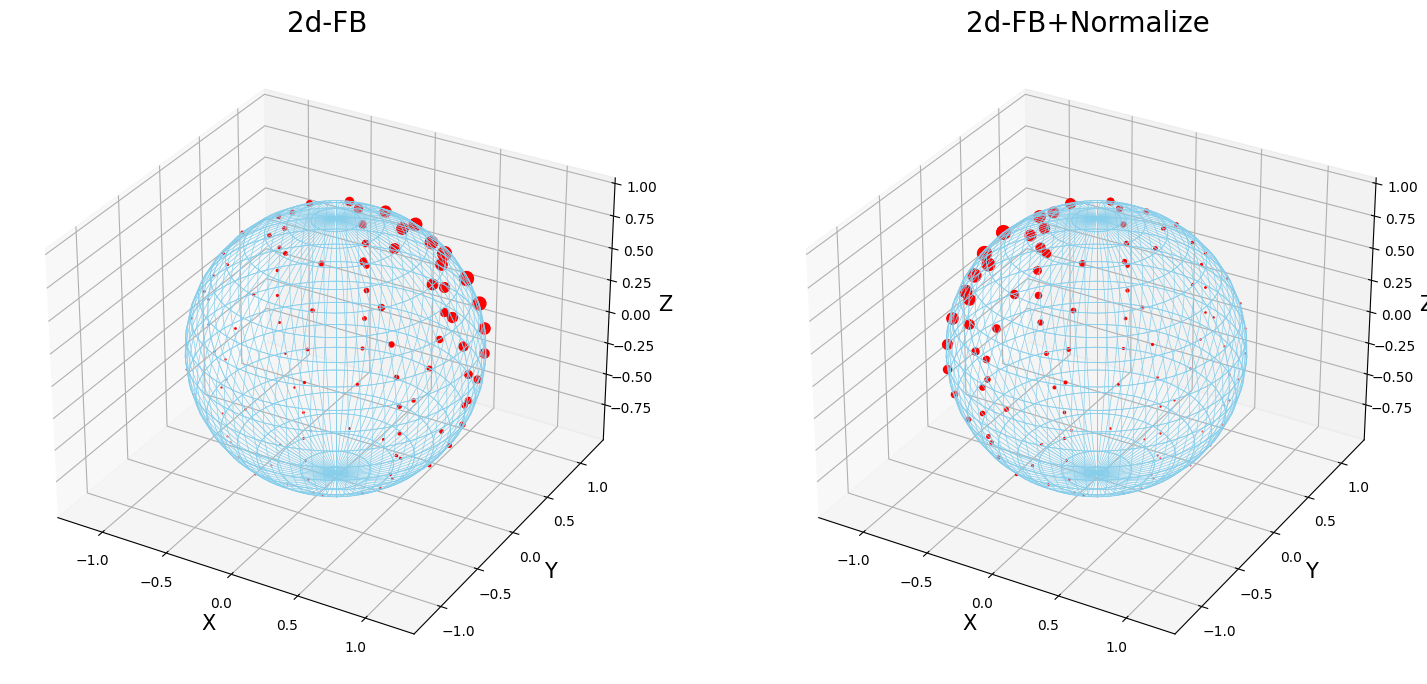

In [118]:
# eig=[2,3,5]
# S=ortho_group.rvs(len(eig))
# Sig= S@np.diag(eig)@S.T
Sig=np.eye(3)
mu=[1,1,1]
# mu=[0,3,-1]
print(np.linalg.eig(Sig)[0])

myhist,rad = hist_gene_3d(Sig,mu,multi=1e3,out_shape=(10,10))

rot_hist,zrad = z_Normalize_3d(myhist)
print(zrad)

fig = plot_3dFB(myhist,figsize=(18,10),axes=(1,2,1),title="2d-FB")
plot_3dFB(rot_hist,fig,axes=(1,2,2),title="2d-FB+Normalize")
plt.show()

In [116]:
print(5-np.unravel_index(np.argmax(myhist), (10,10))[1])
print(int(zrad*5/np.pi))

4
4


[1. 1. 1.]


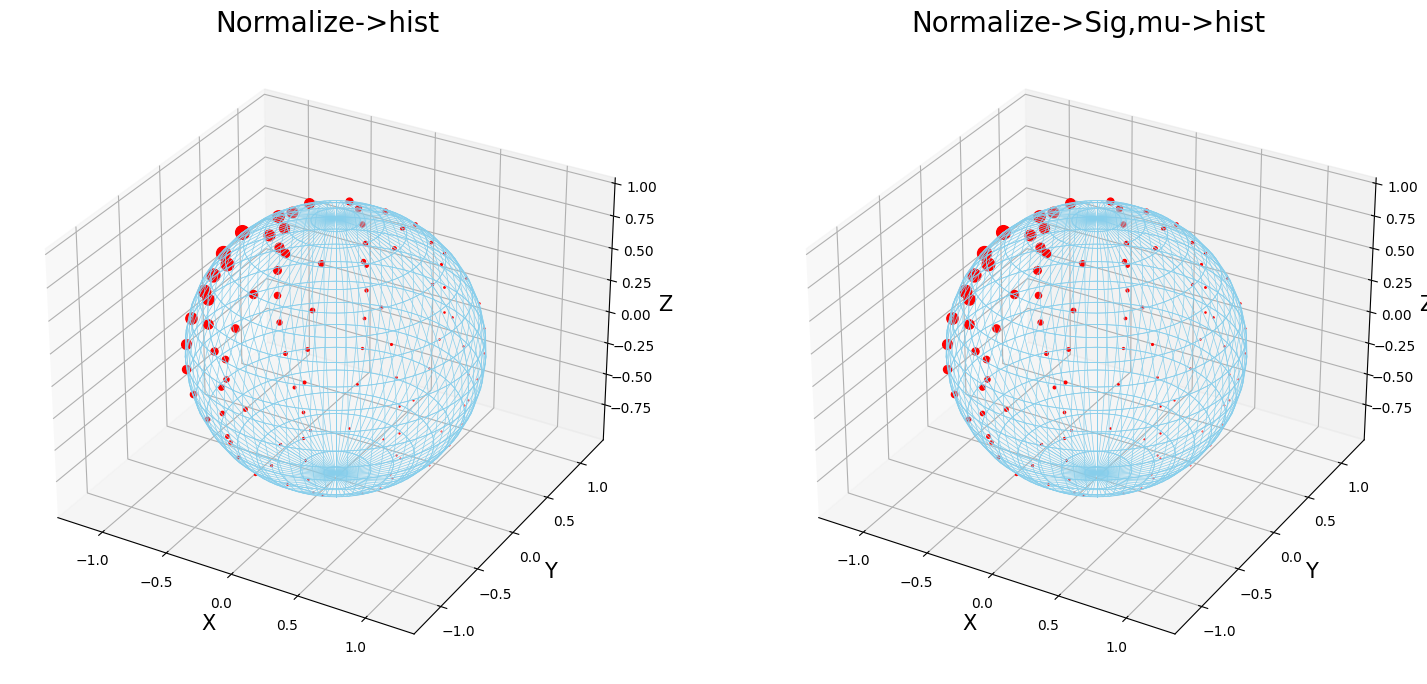

In [ ]:
rot_Sig0 = z_rot(-zrad).T@Sig@z_rot(-zrad)
rot_mu0  = z_rot(zrad)@mu
print(np.linalg.eig(rot_Sig0)[0])
rot_hist0,rad0 = hist_gene_3d(rot_Sig0,rot_mu0,multi=-1,out_shape=(10,10))

fig = plot_3dFB(rot_hist,figsize=(18,10),axes=(1,2,1),title="Normalize->hist")
plot_3dFB(rot_hist0,fig,axes=(1,2,2),title="Normalize->Sig,mu->hist")
plt.show()

[ 2.4493906  -0.16709259  0.72322243  1.761826    0.5323314   2.1854572
 -0.64035976 -2.1322124   7.636397  ]
[1.1385419 3.091781  2.166351 ]
[3.09178079 2.16635113 1.138542  ]


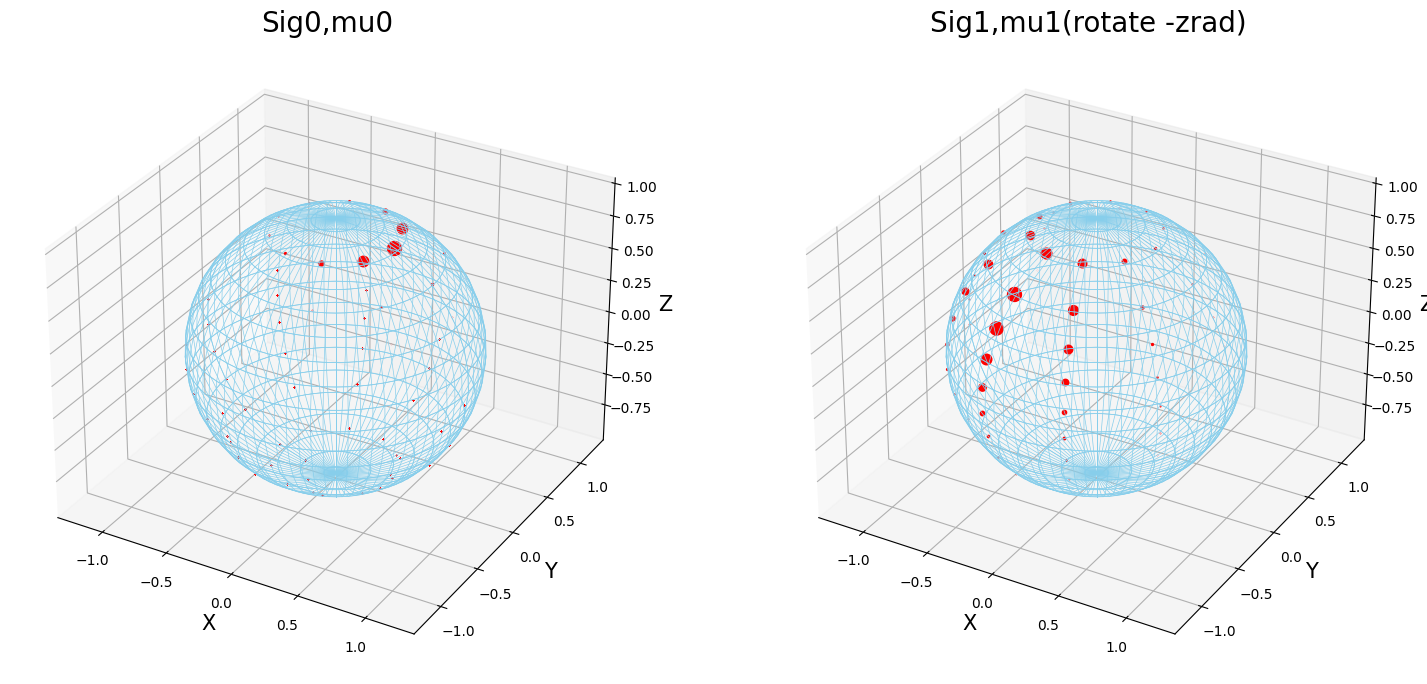

In [129]:
model = keras.models.load_model("./models/mymodel_3d4.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])
# pred = model.predict(np.array([rot_hist.reshape(-1)]),verbose=0)[0]
pred = model.predict(rot_hist.reshape(1,100),verbose=0)[0]
print(pred)

pred=list(pred)
Sig0 = np.array([pred[0:3],pred[1:2]+pred[3:5],pred[2:3]+pred[4:5]+pred[5:6]])
mu0 = np.array(pred[6:])
print(np.linalg.eig(Sig0)[0])
hist0,rad0 = hist_gene_3d(Sig0,mu0,multi=-1,out_shape=(10,10))

Sig1 = z_rot(zrad).T@Sig0@z_rot(zrad)
mu1  = z_rot(-zrad)@mu
print(np.linalg.eig(Sig1)[0])
hist1,rad1 = hist_gene_3d(Sig1,mu1,multi=-1,out_shape=(10,10))

fig = plot_3dFB(hist0,figsize=(18,10),axes=(1,2,1),title="Sig0,mu0")
plot_3dFB(hist1,fig,axes=(1,2,2),title="Sig1,mu1(rotate -zrad)")
plt.show()

In [155]:
O = np.linalg.eig(Sig)[1].T
O = np.diag(np.sign(O@Sig@mu)+1e-2)@O
th_T = np.diag(O@Sig@O.T)/2
ga_T = O@Sig@mu
# print(th_T,ga_T)
# print(O)

O1 = np.linalg.eig(Sig1)[1].T
O1 = np.diag(np.sign(O1@Sig1@mu1)+1e-2)@O1
th1 = np.diag(O1@Sig1@O1.T)/2
ga1 = O1@Sig1@mu1

A,B,n = AB_gene_3d(myhist)
lo=Loglikelihood(th_T,ga_T,A,B,O=O,n=1,method="SPA")
print("True logL:",lo)
# pprint.pprint(Loglikelihood(th_T,ga_T,A,B,O=O,n=1,method="power"))
pprint.pprint(Loglikelihood(th1,ga1,A,B,O=O1,n=1,method="hg"))

True logL: -2.143420539781273
{'grad': array([ 0.31120149, -0.13684237, -0.16783373, -0.83348039,  0.07282601,
       -0.48265395]),
 'log': -5.3139444740016195}


In [148]:
mle = optimisation(th1,ga1,A,B,n=1,O=O1,tol=1e-4,iterss=200,t0=1,
                    orth="yes",sqrt=False)
pprint.pprint(mle)

0.25169423942782276 0.6593445363599775 -2.6740007992421404
-10.532761463605512 7.5367509850503644
iteration
1 0.25169423942782276 0.6593445363599775 0.8374761444667073 -2.2699399075795768 0.40406089166256365
-0.7040884388349363 0.005467408595710089
iteration
2 0.11644629821458974 0.6666434620857766 0.3193264563828229 -2.2247808259332182 0.04515908164635851
-0.7886396343668745 0.0008369267831602889
iteration
3 0.07898007091817516 0.45893601538308254 0.20806651891186795 -2.200064453409148 0.02471637252407044
-0.8857380884143269 0.0009556192841184485
iteration
4 0.04623634091991358 0.3461312924512908 0.14512954538834702 -2.1856489205311087 0.014415532878039095
-0.9524090598702318 0.0008070713748182324
iteration
5 0.04518797094312266 0.2564785433543407 0.1237316762952961 -2.176417224444721 0.009231696086387853
-1.0029559841189053 0.0006144560502087121
iteration
6 0.06847706395493924 0.19063577963805906 0.11357563216639743 -2.1698738945827696 0.006543329861951275
-1.0398606567786006 0.00044

In [150]:
th_mle,ga_mle=mle["th"],mle["gg"]
O_mle=mle["O"]

# Sig_mle = O_mle.T@(np.diag(th_mle*2))@O_mle
Sig_mle = O_mle.T@(np.diag(th_mle))@O_mle
mu_mle = np.linalg.inv(Sig_mle)@O_mle.T@ga_mle
print(Sig_mle)
print(mu_mle)

[[ 1.10319705  0.06381741 -0.02789628]
 [ 0.06381741  1.06487088  0.01713541]
 [-0.02789628  0.01713541  1.13215363]]
[0.90459681 0.8763334  0.89189111]


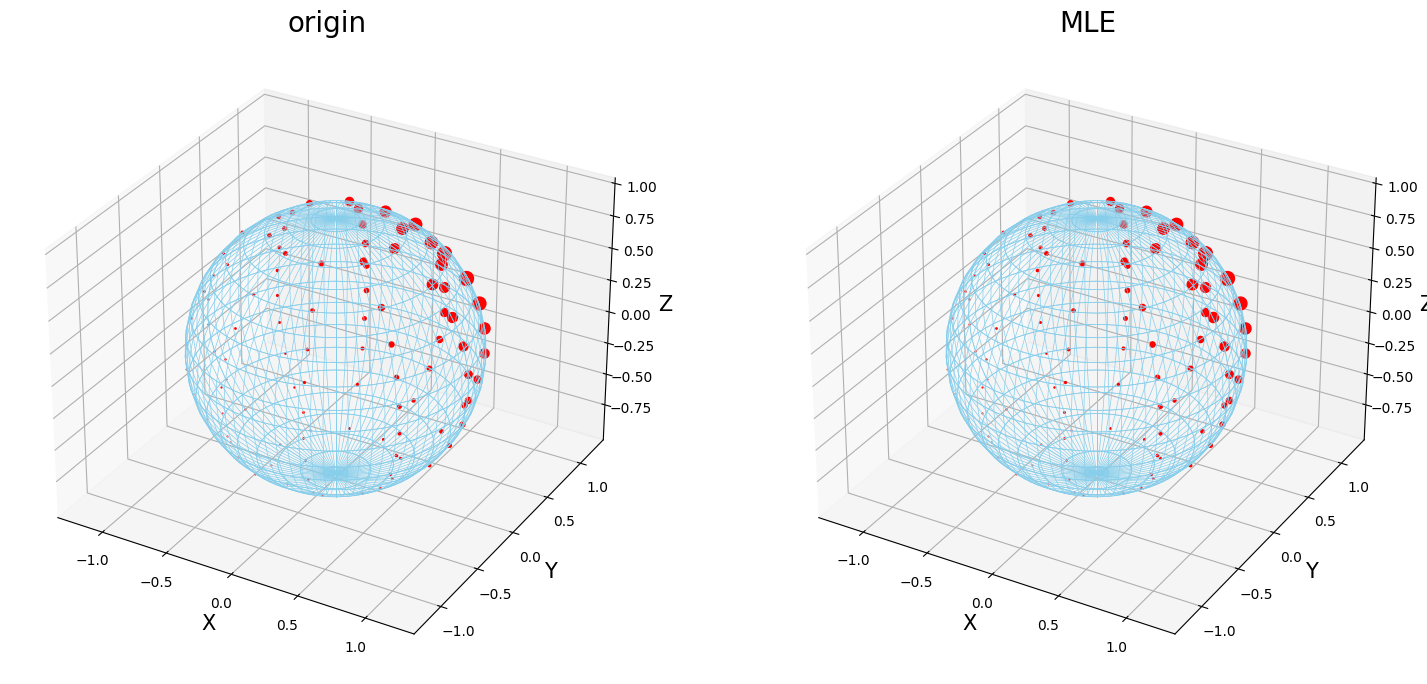

In [151]:
hist_mle,rad_mle = hist_gene_3d(Sig_mle,mu_mle,multi=-1,out_shape=(10,10))

fig = plot_3dFB(myhist,figsize=(18,10),axes=(1,2,1),title="origin")
plot_3dFB(hist_mle,fig,axes=(1,2,2),title="MLE")
plt.show()